In [1]:
%load_ext autoreload
%autoreload 2
from resample import subsample_subdataset
import numpy as np
from utils import evaluate, fair_check

from pyhealth.datasets import MIMIC3Dataset

SENS_KEY = 'gender'
root = '/data/qf31/EHR-Fair-Bench/fairbench/datasets/mimic-iii-clinical-database-1.4'
mimic3base = MIMIC3Dataset(
    root=root,
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"], # PRESCRIPTIONS
    # map all NDC codes to ATC 3-rd level codes in these tables
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    dev=True,
)

In [2]:
from pyhealth.tasks import drug_recommendation_mimic3_fn, mortality_prediction_mimic3_fn, readmission_prediction_mimic3_fn
from pyhealth.datasets import split_by_patient, get_dataloader
from tasks import add_feature
#from tasks import drug_recommendation_mimic3_fn
mimic3sample = mimic3base.set_task(task_fn=mortality_prediction_mimic3_fn) # use default task
mimic3sample = add_feature(mimic3sample, mimic3base, [SENS_KEY])
train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.6, 0.2, 0.2])

# create dataloaders (torch.data.DataLoader)
train_loader = get_dataloader(train_ds, batch_size=3200, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=3200, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=3200, shuffle=False)

Generating samples for mortality_prediction_mimic3_fn: 100%|██████████| 5000/5000 [00:00<00:00, 90760.26it/s]


In [13]:
train_ds.__dir__()

['dataset',
 'indices',
 '__module__',
 '__annotations__',
 '__doc__',
 '__init__',
 '__getitem__',
 '__len__',
 '__orig_bases__',
 '__parameters__',
 '__add__',
 '__dict__',
 '__weakref__',
 '__slots__',
 '__new__',
 '__class_getitem__',
 '__init_subclass__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [3]:
mimic3sample.samples[0].keys()

dict_keys(['visit_id', 'patient_id', 'conditions', 'procedures', 'drugs', 'label', 'gender', 'ethnicity'])

In [25]:
mimic3sample.input_info

{'visit_id': {'type': str, 'dim': 0},
 'patient_id': {'type': str, 'dim': 0},
 'conditions': {'type': str, 'dim': 3},
 'procedures': {'type': str, 'dim': 3},
 'drugs': {'type': str, 'dim': 3},
 'label': {'type': int, 'dim': 0},
 'gender': {'type': str, 'dim': 0}}

In [4]:
getattr(mimic3base.patients['10'], 'gender')

'F'

In [4]:
mimic3sample.get_all_tokens(key='gender', remove_duplicates=False, sort=False)

['F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M'

In [6]:
mimic3sample.input_info

{'visit_id': {'type': str, 'dim': 0},
 'patient_id': {'type': str, 'dim': 0},
 'conditions': {'type': str, 'dim': 3},
 'procedures': {'type': str, 'dim': 3},
 'drugs': {'type': str, 'dim': 3},
 'label': {'type': int, 'dim': 0},
 'gender': {'type': str, 'dim': 0},
 'ethnicity': {'type': str, 'dim': 0}}

In [20]:
from pyhealth.models import Transformer
from models import Adv_Transformer,Laftr_Transformer, LNL_Transformer, CFair_Transformer, LNL_Trainer, AFAL_Transformer, AFAL_Trainer
model = AFAL_Transformer(
    dataset=mimic3sample,# the dataset should provide sens feat
    feature_keys=["conditions", "procedures", "drugs"], # the model should specify the sens feat
    label_key="label",
    sens_key='gender',
    mode="binary",
    sens_mode = 'binary',
    alpha=0.0
    #fair_coeff=0.0,
    #model_var='laftr-dp'
    # the model should provide sensitive attribute
)

set binary mode to multiclass
set binary sens mode to multiclass


In [13]:
new_list = [_ for _ in list(model.named_parameters()) if 'sens_fc' not in _[0]]
new_list

[('_dummy_param',
  Parameter containing:
  tensor([], requires_grad=True)),
 ('embeddings.conditions.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2991, -1.1321, -0.5520,  ..., -1.4299,  0.5636, -0.2250],
          [ 0.6280, -0.7186, -1.4664,  ...,  0.3803, -0.8594, -1.4790],
          ...,
          [-0.7312,  0.7167,  1.4183,  ..., -0.9104,  0.7194, -0.4060],
          [ 0.8302,  0.0649,  0.3679,  ...,  1.7737, -0.7138, -1.0214],
          [-0.6989, -1.6174,  0.6055,  ..., -0.4188, -2.4469,  0.4839]],
         requires_grad=True)),
 ('embeddings.procedures.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.2388, -0.1898,  2.4136,  ...,  0.7203,  1.9647,  1.1141],
          [ 0.1445,  0.4033,  0.7733,  ...,  0.2681, -0.0702,  0.5828],
          ...,
          [-0.6485,  1.0995,  0.4942,  ..., -1.1189, -0.9046,  0.3469],
          [-1.2243, -0.36

In [8]:
model.sens_tokenizer.vocabulary.token2idx

{'F': 0, 'M': 1}

In [7]:
model.sens_tokenizer.convert_tokens_to_indices(['F', 'F'])

[0, 0]

In [5]:
model.label_tokenizer.get_vocabulary_size()

2

In [14]:
model.prepare_labels(kwargs[model.label_key], model.label_tokenizer)

<function pyhealth.models.base_model.BaseModel.prepare_labels(self, labels: Union[List[str], List[List[str]]], label_tokenizer: pyhealth.tokenizer.Tokenizer) -> torch.Tensor>

In [9]:
model.dataset.__len__()

233

In [40]:
model.dataset.get_all_tokens('gender')[0]

'F'

In [29]:
A = model.dataset.get_all_tokens(model.sens_key, remove_duplicates=False, sort=False)
Y = model.dataset.get_all_tokens(model.label_key, remove_duplicates=False, sort=False)
ttl = model.dataset.__len__()

In [23]:
import torch
torch.empty(3, dtype=torch.long).random_(5)

tensor([4, 2, 3])

In [21]:
trainer = AFAL_Trainer(model=model,device='cuda:0', metrics=['roc_auc_macro_ovo'])

AFAL_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(1674, 256, padding_idx=0)
    (procedures): Embedding(571, 256, padding_idx=0)
    (drugs): Embedding(178, 256, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=256, out_features=256, bias=False)
              (1): Linear(in_features=256, out_features=256, bias=False)
              (2): Linear(in_features=256, out_features=256, bias=False)
            )
            (output_linear): Linear(in_features=256, out_features=256, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=256, out_features=1024, bias=True)
      

In [23]:
#trainer = Trainer(model=model,device='cuda:0')
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    monitor='roc_auc_macro_ovo',#"pr_auc_samples",
    #adv_rate = 10.0,
)

Training:
Batch size: 3200
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.0001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f7dc3594f50>
Monitor: roc_auc_macro_ovo
Monitor criterion: max
Epochs: 10



Epoch 0 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-0, step-1 ---
loss: 1.3564, sens_loss: 0.8778
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 40.40it/s]
--- Eval epoch-0, step-1 ---
roc_auc_macro_ovo: 0.5341
loss: 0.8216
New best roc_auc_macro_ovo score (0.5341) at epoch-0, step-1



Epoch 1 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-1, step-2 ---
loss: 1.1419, sens_loss: 0.8487
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 41.25it/s]
--- Eval epoch-1, step-2 ---
roc_auc_macro_ovo: 0.5306
loss: 0.6481



Epoch 2 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-2, step-3 ---
loss: 0.9873, sens_loss: 0.8211
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s]
--- Eval epoch-2, step-3 ---
roc_auc_macro_ovo: 0.5293
loss: 0.5358



Epoch 3 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-3, step-4 ---
loss: 0.9896, sens_loss: 0.8133
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 34.77it/s]
--- Eval epoch-3, step-4 ---
roc_auc_macro_ovo: 0.5319
loss: 0.4694



Epoch 4 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-4, step-5 ---
loss: 0.8430, sens_loss: 0.7930
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s]
--- Eval epoch-4, step-5 ---
roc_auc_macro_ovo: 0.5346
loss: 0.4359
New best roc_auc_macro_ovo score (0.5346) at epoch-4, step-5



Epoch 5 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-5, step-6 ---
loss: 0.6908, sens_loss: 0.7749
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 42.60it/s]
--- Eval epoch-5, step-6 ---
roc_auc_macro_ovo: 0.5380
loss: 0.4243
New best roc_auc_macro_ovo score (0.5380) at epoch-5, step-6



Epoch 6 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-6, step-7 ---
loss: 0.6253, sens_loss: 0.7911
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 37.92it/s]
--- Eval epoch-6, step-7 ---
roc_auc_macro_ovo: 0.5346
loss: 0.4262



Epoch 7 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-7, step-8 ---
loss: 0.6121, sens_loss: 0.7935
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 37.84it/s]
--- Eval epoch-7, step-8 ---
roc_auc_macro_ovo: 0.5346
loss: 0.4363



Epoch 8 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-8, step-9 ---
loss: 0.5496, sens_loss: 0.8044
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 37.66it/s]
--- Eval epoch-8, step-9 ---
roc_auc_macro_ovo: 0.5328
loss: 0.4508



Epoch 9 / 10:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-9, step-10 ---
loss: 0.5595, sens_loss: 0.7881
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]
--- Eval epoch-9, step-10 ---
roc_auc_macro_ovo: 0.5354
loss: 0.4673
Loaded best model


In [24]:
from utils import fair_check, evaluate
evaluate(trainer, train_loader)

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


{'roc_auc_macro_ovo': 0.5536137440758293, 'loss': 0.41003865003585815}

In [11]:
from utils import fair_check, evaluate
evaluate(trainer, test_loader)

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.57it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


{'roc_auc_macro_ovo': 0.6, 'loss': 1.501630187034607}

In [9]:
from utils import fair_check
fair_check(trainer, test_loader)

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 177.41it/s]


{'roc_auc': 0.32962962962962955}

In [18]:
from utils import fair_check
fair_check(trainer, test_loader)

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 188.66it/s]


{'roc_auc': 0.03872053872053871}

In [31]:
final_result = {}
for subsample_rate in [0.0, 0.25, 0.5, 0.75, 1.0]:
    final_result[subsample_rate] = {'auc':[], 'auc_diff': []}
    for _ in range(3):
        model = Adv_Transformer(
            dataset=mimic3sample,# the dataset should provide sens feat
            feature_keys=["conditions", "procedures"], # the model should specify the sens feat
            label_key="drugs",
            sens_key='gender',
            mode="multilabel",
            sens_mode = 'multiclass',
            # the model should provide sensitive attribute   
        )
        trainer = Trainer(model=model,device='cuda:0')

        #trainer = Trainer(model=model,device='cuda:0')
        trainer.train(
            train_dataloader= get_dataloader(subsample_subdataset(train_ds, 'gender', subsample_rate), batch_size=32, shuffle=True),
            val_dataloader=val_loader,
            epochs=1,
            monitor="pr_auc_samples",
            #adv_rate = subsample_rate,
        )
        
        final_result[subsample_rate]['auc'] += [evaluate(trainer, test_loader)['pr_auc_samples']]
        final_result[subsample_rate]['auc_diff'] += [fair_check(trainer, test_loader)['pr_auc_samples']]

    final_result[subsample_rate]['auc'] = {'mean': np.mean(final_result[subsample_rate]['auc']), 'std': np.std(final_result[subsample_rate]['auc'])}
    final_result[subsample_rate]['auc_diff'] = {'mean': np.mean(final_result[subsample_rate]['auc_diff']), 'std': np.std(final_result[subsample_rate]['auc_diff'])}



Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=1

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0005
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.32it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3443
loss: 0.6593
New best pr_auc_samples score (0.3443) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.21it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0498
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.91it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3190
loss: 0.7097
New best pr_auc_samples score (0.3190) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.65it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0407
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.23it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3387
loss: 0.7055
New best pr_auc_samples score (0.3387) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.96it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0234
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.27it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3554
loss: 0.6835
New best pr_auc_samples score (0.3554) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 147.00it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0253
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 133.28it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3074
loss: 0.7304
New best pr_auc_samples score (0.3074) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.83it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0102
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.16it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3488
loss: 0.7025
New best pr_auc_samples score (0.3488) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.67it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 0.9957
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.63it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3522
loss: 0.6790
New best pr_auc_samples score (0.3522) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.41it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0567
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.66it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3192
loss: 0.6907
New best pr_auc_samples score (0.3192) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.85it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0248
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.65it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3222
loss: 0.6956
New best pr_auc_samples score (0.3222) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 143.96it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0544
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.34it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3168
loss: 0.7513
New best pr_auc_samples score (0.3168) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.97it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0383
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.64it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3055
loss: 0.7355
New best pr_auc_samples score (0.3055) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.11it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0025
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.48it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3541
loss: 0.6986
New best pr_auc_samples score (0.3541) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.24it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0599
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 172.71it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3232
loss: 0.6860
New best pr_auc_samples score (0.3232) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 147.57it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0018
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.79it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3460
loss: 0.6723
New best pr_auc_samples score (0.3460) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.83it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0493
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.97it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3101
loss: 0.7444
New best pr_auc_samples score (0.3101) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.25it/s]


In [10]:
(final_result[0.0]['auc'])

{'mean': 0.30370512899526597, 'std': 0.026583837395578767}

In [16]:
(final_result[0.0]['auc_diff'])

{'mean': 0.09379999239964172, 'std': 0.020344631310541664}

In [12]:
torch.save(final_result, 'adv_test_result')

In [12]:
import torch

In [13]:
final_result = torch.load('subsample_test_result')

In [14]:
from matplotlib import pyplot as plt

In [15]:
auc_list = [final_result[adv_rate]['auc']['mean'] for adv_rate in final_result.keys()]
auc_std_list = [final_result[adv_rate]['auc']['std'] for adv_rate in final_result.keys()]

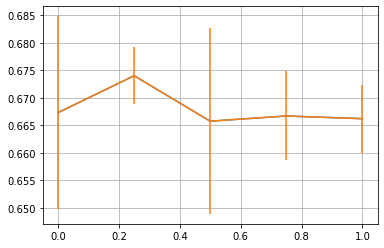

In [16]:
plt.plot(list(final_result.keys()), auc_list)
plt.errorbar(final_result.keys(), auc_list, yerr=auc_std_list, label='both limits (default)')
#plt.xscale('log')
plt.grid()

In [17]:
auc_diff_list = [final_result[adv_rate]['auc_diff']['mean'] for adv_rate in final_result.keys()]
auc__diff_std_list = [final_result[adv_rate]['auc_diff']['std'] for adv_rate in final_result.keys()]

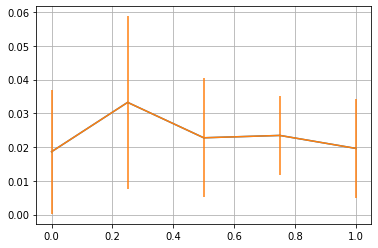

In [18]:
plt.plot(list(final_result.keys()), auc_diff_list)
plt.errorbar(final_result.keys(), auc_diff_list, yerr=auc__diff_std_list, label='both limits (default)')
#plt.xscale('log')
plt.grid()

In [ ]:
[0.0, 0.1, 1.0, 10.0]

In [ ]:
train_ds = subsample_subdataset(train_ds)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)